In [1]:
from IPython.core.magic import register_cell_magic
import os
from pathlib import Path

## define custom magic to save most useful classes and use them in inference notebook 
## instead of copying the code every time you have changes in the classes
@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)
    
Path('/kaggle/working/scripts').mkdir(exist_ok=True)
models_dir = Path('/kaggle/working/models')
models_dir.mkdir(exist_ok=True)

In [2]:
%%write_and_run scripts/imports.py

import os
import gc
import sys
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, Sampler
from torch.cuda.amp import autocast, GradScaler

from transformers import (AutoModel,AutoTokenizer, AutoConfig, get_cosine_schedule_with_warmup)

from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
y_ = Fore.YELLOW
m_ = Fore.MAGENTA
w_ = Fore.WHITE
bb_ = Back.BLACK
sr_ = Style.RESET_ALL

In [3]:
%%write_and_run scripts/config.py

class Config:
    model_name = 'roberta-large'
    output_hidden_states = True
    nfolds = 5
    epochs = 5
    batch_size = 8
    device = 'cuda'
    seed = 42
    max_len = 256
    lr = 1e-5
    wd = 0.01
    eval_schedule = [(float('inf'), 40), (0.47, 20), (0.46, 10), (0, 0)]
    gradient_accumulation = 2
    pre_trained_model = '../input/clrp-roberta-large-pretrain-on-gpu/clrp_roberta_large'

In [4]:
def rmse_score(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=Config.seed)

In [5]:
train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
sample = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')

num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data.loc[:,'bins'] = pd.cut(train_data['target'],bins=num_bins,labels=False)

bins = train_data.bins.to_numpy()
target = train_data.target.to_numpy()

for i in range(Config.nfolds):
    os.makedirs(f'model{i}',exist_ok=True)
    
train_data['Fold'] = -1
kfold = StratifiedKFold(n_splits=Config.nfolds,shuffle=True,random_state=Config.seed)
for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train_data,y=bins)):
    train_data.loc[valid_idx,'Fold'] = k

train_data.head()

,id,url_legal,license,excerpt,target,standard_error,bins,Fold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,7,0
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,7,2
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,6,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,5,2
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,8,1


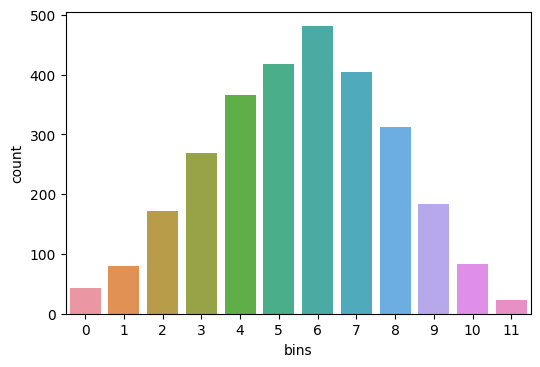

In [6]:
plt.figure(dpi=100)
sns.countplot(train_data.bins);

In [7]:
%%write_and_run scripts/dataset.py

def convert_examples_to_features(text, tokenizer, max_len):

    tok = tokenizer.encode_plus(
        text, 
        max_length=max_len, 
        truncation=True,
        padding='max_length',
    )
    return tok


class CLRPDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, is_test=False):
        self.data = data
        self.excerpts = self.data.excerpt.tolist()
        if not is_test:
            self.targets = self.data.target.tolist()
            
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        if not self.is_test:
            excerpt = self.excerpts[item]
            label = self.targets[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, self.max_len
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
                'label':torch.tensor(label, dtype=torch.float),
            }
        else:
            excerpt = self.excerpts[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, self.max_len
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
            }

In [8]:
%%write_and_run scripts/model.py

class AttentionHead(nn.Module):
    def __init__(self, h_size, hidden_dim=512):
        super().__init__()
        self.W = nn.Linear(h_size, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        
    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector
    
class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None else nn.Parameter(torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float))

    def forward(self, all_hidden_states):
        all_layer_embedding = all_hidden_states[self.layer_start:, :, :, :]
        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()
        return weighted_average

class CLRPModel(nn.Module):
    def __init__(self,path):
        super(CLRPModel,self).__init__()
        config = AutoConfig.from_pretrained(path)
        config.update({"output_hidden_states":True, "hidden_dropout_prob": 0.0,"layer_norm_eps": 1e-7}) 
        self.roberta = AutoModel.from_pretrained(path,config=config) 
        self.pooler = WeightedLayerPooling(config.num_hidden_layers, layer_start=21, layer_weights=None)
        self.head1 = AttentionHead(config.hidden_size*4)
        self.head2 = AttentionHead(config.hidden_size)
        self.linear_out = nn.Linear(config.hidden_size*11, 1)
              
    def forward(self, input_ids, attention_mask):
        roberta_out = self.roberta(input_ids, attention_mask)
        all_hidden_states = torch.stack(roberta_out.hidden_states)                                                                                                   # (25, 8, 256, 1024)   
        # print(f'all_hidden_states Shape: {all_hidden_states.cpu().detach().numpy().shape}')
        
        
        layer_index = 23 # second to last hidden layer
        cls_embeddings = all_hidden_states[layer_index+1, :, 0] # layer_index+1 as we have 24 layers (embedding + num of blocks)                                                (8, 1024)
        # print(f'cls_embeddings Shape: {cls_embeddings.cpu().detach().numpy().shape}')
        
        
        concat_4last_layers = torch.cat((all_hidden_states[-1],all_hidden_states[-2],all_hidden_states[-3], all_hidden_states[-4]),-1)                                    # (8, 256, 4096)
        # print(f'concat_last_4layers Shape: {concat_4last_layers.cpu().detach().numpy().shape}')
        concat_cls_pooling = concat_4last_layers[:, 0]                                                                                                                         # (8, 4096)
        # print(f'concat_cls_pooling Shape: {concat_cls_pooling.cpu().detach().numpy().shape}')
        last_layer_logits = self.head1(concat_4last_layers)                                                                                                                    # (8, 4096)
        # print(f'last_layer_logits Shape: {last_layer_logits.cpu().detach().numpy().shape}')                                                                                        # (8,)
        
        
        weighted_pooling_embeddings = self.pooler(all_hidden_states)                                                                                                     # (8, 256, 1024)
        # print(f'weighted_pooling_embeddings Shape: {weighted_pooling_embeddings.cpu().detach().numpy().shape}')
        weighted_pooling = weighted_pooling_embeddings[:, 0]                                                                                                                  # (8, 1024)
        # print(f'weighted_pooling Shape: {weighted_pooling.cpu().detach().numpy().shape}')
        weighted_pooling_logits = self.head2(weighted_pooling_embeddings)                                                                                                     # (8, 1024) 
        # print(f'weighted_pooling_logits Shape: {weighted_pooling_logits.cpu().detach().numpy().shape}')
        
        final_concat = torch.cat([cls_embeddings, concat_cls_pooling, last_layer_logits, weighted_pooling, weighted_pooling_logits], -1)
        # print(f'final_concat Shape: {final_concat.shape}')
        y_hat = self.linear_out(final_concat)                                                                                                                     # [8, 10177] --> (8, 1)
        # print(f'y_hat Shape: {y_hat.cpu().detach().numpy().shape}')
        
        
        return y_hat

In [9]:
def create_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    roberta_parameters = named_parameters[:389]                   #  N1:               
    attention_parameters = named_parameters[391:392]              #  [389:392]        
    regressor_parameters = named_parameters[392:]                 #  [392:]            
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})
    
    # increase lr every second layer
    increase_lr_every_k_layer = 1
    lrs = np.linspace(1, 5, 24 // increase_lr_every_k_layer)
    for layer_num, (name, params) in enumerate(roberta_parameters):
        weight_decay = 0.0 if "bias" in name else 0.01
        splitted_name = name.split('.')
        lr = Config.lr
        if len(splitted_name) >= 4 and str.isdigit(splitted_name[3]):
            layer_num = int(splitted_name[3])
            lr = lrs[layer_num // increase_lr_every_k_layer] * Config.lr 

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return optim.AdamW(parameters)

class DynamicPadCollate:
    def __call__(self,batch):
                
        out = {'input_ids' :[],
               'attention_mask':[],
               'label':[]}
        
        for i in batch:
            for k,v in i.items():
                out[k].append(v)
                
        max_pad =0

        for p in out['input_ids']:
            if max_pad < len(p):
                max_pad = len(p)   

        for i in range(len(batch)):
            
            input_id = out['input_ids'][i]
            att_mask = out['attention_mask'][i]
            text_len = len(input_id)
            
            out['input_ids'][i] = (out['input_ids'][i].tolist() + [1] * (max_pad - text_len))[:max_pad]
            out['attention_mask'][i] = (out['attention_mask'][i].tolist() + [0] * (max_pad - text_len))[:max_pad]
        
        out['input_ids'] = torch.tensor(out['input_ids'],dtype=torch.long)
        out['attention_mask'] = torch.tensor(out['attention_mask'],dtype=torch.long)
        out['label'] = torch.tensor(out['label'],dtype=torch.float)
        
        return out

class AvgCounter:
    def __init__(self):
        self.reset()
        
    def update(self, loss, n_samples):
        self.loss += loss * n_samples
        self.n_samples += n_samples
        
    def avg(self):
        return self.loss / self.n_samples
    
    def reset(self):
        self.loss = 0
        self.n_samples = 0

class EvaluationScheduler:
    def __init__(self, evaluation_schedule, penalize_factor=1, max_penalty=8):
        self.evaluation_schedule = evaluation_schedule
        self.evaluation_interval = self.evaluation_schedule[0][1]
        self.last_evaluation_step = 0
        self.prev_loss = float('inf')
        self.penalize_factor = penalize_factor
        self.penalty = 0
        self.prev_interval = -1
        self.max_penalty = max_penalty

    def step(self, step):
        # should we to make evaluation right now
        if step >= self.last_evaluation_step + self.evaluation_interval:
            self.last_evaluation_step = step
            return True
        else:
            return False
        
            
    def update_evaluation_interval(self, last_loss):
        # set up evaluation_interval depending on loss value
        cur_interval = -1
        for i, (loss, interval) in enumerate(self.evaluation_schedule[:-1]):
            if self.evaluation_schedule[i+1][0] < last_loss < loss:
                self.evaluation_interval = interval
                cur_interval = i
                break
            
        self.prev_loss = last_loss
        self.prev_interval = cur_interval
        
def make_dataloader(data, tokenizer, is_train=True):
    dataset = CLRPDataset(data, tokenizer=tokenizer, max_len=Config.max_len)
    if is_train:sampler = RandomSampler(dataset)
    else:       sampler = SequentialSampler(dataset)

    batch_dataloader = DataLoader(dataset, sampler=sampler, batch_size=Config.batch_size, pin_memory=True, collate_fn=DynamicPadCollate())
    return batch_dataloader
        
def mse_loss(y_true,y_pred):
    return nn.functional.mse_loss(y_true,y_pred)

In [10]:
class Trainer:
    def __init__(self, train_dl, val_dl, model, optimizer, scheduler, scaler, criterion, model_num):
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = Config.device
        self.batches_per_epoch = len(self.train_dl)
        self.total_batch_steps = self.batches_per_epoch * Config.epochs
        self.criterion = criterion
        self.model_num = model_num
        
        self.scaler = scaler
                
    def run(self):
        record_info = {'train_loss': [],
                       'val_loss': [],}
        
        best_val_loss = float('inf')
        evaluation_scheduler = EvaluationScheduler(Config.eval_schedule)
        train_loss_counter = AvgCounter()
        step = 0
        
        for epoch in range(Config.epochs):
            
            print(f'{r_}Epoch: {epoch+1}/{Config.epochs}{sr_}')
            start_epoch_time = time()
            
            for batch_num, batch in enumerate(self.train_dl):
                train_loss = self.train(batch, step)
#                 print(f'{epoch+1}#[{step+1}/{len(self.train_dl)}]: train loss - {train_loss.item()}')

                train_loss_counter.update(train_loss, len(batch))
                record_info['train_loss'].append((step, train_loss.item()))

                if evaluation_scheduler.step(step):
                    val_loss = self.evaluate()
                    
                    record_info['val_loss'].append((step, val_loss.item()))        
                    print(f'\t\t{self.model_num}-{epoch+1}#[{batch_num+1}/{self.batches_per_epoch}]: train loss - {train_loss_counter.avg()} | val loss - {val_loss}',)
                    train_loss_counter.reset()

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss.item()
                        print(f"\t\t{g_}Val loss decreased from {best_val_loss} to {val_loss}{sr_}")
                        torch.save(self.model, models_dir / f'{self.model.__class__.__name__}_{self.model_num}.pt')
                        
                    evaluation_scheduler.update_evaluation_interval(val_loss.item())
                        
                step += 1
            end_epoch_time = time()
            print(f'{bb_}{y_}The epoch took {end_epoch_time - start_epoch_time} sec..{sr_}')

        return record_info, best_val_loss

    def train(self, batch, batch_step):
        self.model.train()
        sent_id, mask, labels = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device), batch['label'].to(self.device)
        with autocast():
            preds = self.model(sent_id, mask)
            train_loss = self.criterion(preds, labels.unsqueeze(1))
        
        self.scaler.scale(train_loss).backward()
        
        if (batch_step + 1) % Config.gradient_accumulation or batch_step+1 == self.total_batch_steps:
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.model.zero_grad() 
        self.scheduler.step()
        return torch.sqrt(train_loss)

    def evaluate(self):
        self.model.eval()
        val_loss_counter = AvgCounter()

        for step,batch in enumerate(self.val_dl):
            sent_id, mask, labels = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device), batch['label'].to(self.device)
            with torch.no_grad():
                with autocast():
                    preds = self.model(sent_id, mask)
                    loss = self.criterion(preds,labels.unsqueeze(1))
                val_loss_counter.update(torch.sqrt(loss), len(labels))
        return val_loss_counter.avg()
    
def mse_loss(y_true,y_pred):
    return nn.functional.mse_loss(y_true,y_pred)

In [11]:
gc.collect()

3912

  Fold#: 0  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-large-pretrain-on-gpu/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/5
		0-1#[41/284]: train loss - 1.0181021690368652 | val loss - 0.9352584481239319
		Val loss decreased from 0.9352584481239319 to 0.9352584481239319
		0-1#[81/284]: train loss - 0.7750441431999207 | val loss - 0.9028608798980713
		Val loss decreased from 0.9028608798980713 to 0.9028608798980713
		0-1#[121/284]: train loss - 0.72193843126297 | val loss - 0.7480862736701965
		Val loss decreased from 0.7480862736701965 to 0.7480862736701965
		0-1#[161/284]: train loss - 0.6635446548461914 | val loss - 0.6203562617301941
		Val loss decreased from 0.6203562617301941 to 0.6203562617301941
		0-1#[201/284]: train loss - 0.572588324546814 | val loss - 0.5644826889038086
		Val loss decreased from 0.5644826889038086 to 0.5644826889038086
		0-1#[241/284]: train loss - 0.5603139400482178 | val loss - 0.5411422252655029
		Val loss decreased from 0.5411422252655029 to 0.5411422252655029
		0-1#[281/284]: train loss - 0.569410502910614 | val loss - 0.5576505661010742
The epoch took 395.3339622

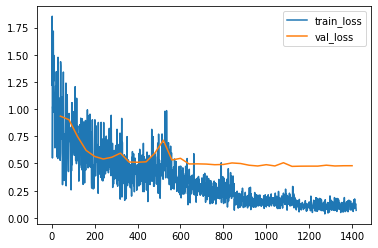

  Fold#: 1  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-large-pretrain-on-gpu/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/5
		1-1#[41/284]: train loss - 1.1211804151535034 | val loss - 0.6850975155830383
		Val loss decreased from 0.6850975155830383 to 0.6850975155830383
		1-1#[81/284]: train loss - 0.6546065807342529 | val loss - 0.8074315190315247
		1-1#[121/284]: train loss - 0.7644447684288025 | val loss - 0.8750843405723572
		1-1#[161/284]: train loss - 0.594582736492157 | val loss - 0.8846467733383179
		1-1#[201/284]: train loss - 0.6734371185302734 | val loss - 0.7484733462333679
		1-1#[241/284]: train loss - 0.7593017816543579 | val loss - 0.6209794878959656
		Val loss decreased from 0.6209794878959656 to 0.6209794878959656
		1-1#[281/284]: train loss - 0.5868381261825562 | val loss - 0.5526022911071777
		Val loss decreased from 0.5526022911071777 to 0.5526022911071777
The epoch took 350.46370220184326 sec..
Epoch: 2/5
		1-2#[37/284]: train loss - 0.4702880084514618 | val loss - 0.5388306379318237
		Val loss decreased from 0.5388306379318237 to 0.5388306379318237
		1-2#[77/284]: train loss

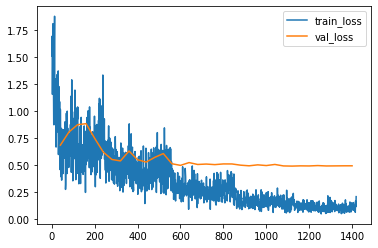

  Fold#: 2  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-large-pretrain-on-gpu/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/5
		2-1#[41/284]: train loss - 1.2423983812332153 | val loss - 0.9435456991195679
		Val loss decreased from 0.9435456991195679 to 0.9435456991195679
		2-1#[81/284]: train loss - 0.7801306843757629 | val loss - 0.6724302172660828
		Val loss decreased from 0.6724302172660828 to 0.6724302172660828
		2-1#[121/284]: train loss - 0.8307555317878723 | val loss - 0.8302279710769653
		2-1#[161/284]: train loss - 0.7043675184249878 | val loss - 0.683536946773529
		2-1#[201/284]: train loss - 0.6155369281768799 | val loss - 0.5434371829032898
		Val loss decreased from 0.5434371829032898 to 0.5434371829032898
		2-1#[241/284]: train loss - 0.5869736671447754 | val loss - 0.5476396083831787
		2-1#[281/284]: train loss - 0.562659502029419 | val loss - 0.5199315547943115
		Val loss decreased from 0.5199315547943115 to 0.5199315547943115
The epoch took 353.6014795303345 sec..
Epoch: 2/5
		2-2#[37/284]: train loss - 0.409945547580719 | val loss - 0.49409276247024536
		Val loss decreased from 0.

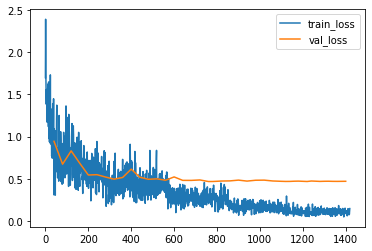

  Fold#: 3  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-large-pretrain-on-gpu/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/5
		3-1#[41/284]: train loss - 1.0663224458694458 | val loss - 0.704020082950592
		Val loss decreased from 0.704020082950592 to 0.704020082950592
		3-1#[81/284]: train loss - 0.7290182709693909 | val loss - 0.6060951948165894
		Val loss decreased from 0.6060951948165894 to 0.6060951948165894
		3-1#[121/284]: train loss - 0.7332862615585327 | val loss - 0.8089290261268616
		3-1#[161/284]: train loss - 0.6335287690162659 | val loss - 0.5804517865180969
		Val loss decreased from 0.5804517865180969 to 0.5804517865180969
		3-1#[201/284]: train loss - 0.6669838428497314 | val loss - 0.7004624605178833
		3-1#[241/284]: train loss - 0.6663395166397095 | val loss - 0.7129120230674744
		3-1#[281/284]: train loss - 0.7035753130912781 | val loss - 0.8100653290748596
The epoch took 350.3791718482971 sec..
Epoch: 2/5
		3-2#[37/284]: train loss - 0.5251268148422241 | val loss - 0.49558591842651367
		Val loss decreased from 0.49558591842651367 to 0.49558591842651367
		3-2#[77/284]: train loss

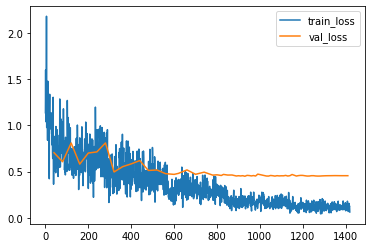

  Fold#: 4  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-large-pretrain-on-gpu/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/5
		4-1#[41/284]: train loss - 0.968156099319458 | val loss - 0.7372747659683228
		Val loss decreased from 0.7372747659683228 to 0.7372747659683228
		4-1#[81/284]: train loss - 0.7128921151161194 | val loss - 0.6423512697219849
		Val loss decreased from 0.6423512697219849 to 0.6423512697219849
		4-1#[121/284]: train loss - 0.6782339811325073 | val loss - 0.603592038154602
		Val loss decreased from 0.603592038154602 to 0.603592038154602
		4-1#[161/284]: train loss - 0.6260488033294678 | val loss - 0.5682339072227478
		Val loss decreased from 0.5682339072227478 to 0.5682339072227478
		4-1#[201/284]: train loss - 0.6709447503089905 | val loss - 0.5914591550827026
		4-1#[241/284]: train loss - 0.533024787902832 | val loss - 0.529277503490448
		Val loss decreased from 0.529277503490448 to 0.529277503490448
		4-1#[281/284]: train loss - 0.575458824634552 | val loss - 0.539411723613739
The epoch took 357.10404324531555 sec..
Epoch: 2/5
		4-2#[37/284]: train loss - 0.4933684468269348 

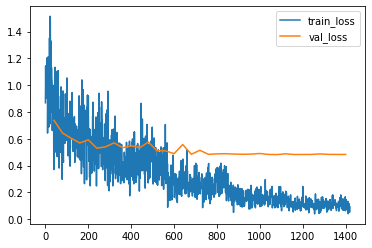

Best val losses: [0.4733539819717407, 0.4908316731452942, 0.4662933051586151, 0.44937843084335327, 0.48164859414100647]
Avg val loss: 0.47230119705200196


In [12]:
best_scores = []

for fold in range(Config.nfolds): 
    print(f'{bb_}{w_}  Fold#: {fold}  {sr_}')

    tokenizer = AutoTokenizer.from_pretrained('../input/huggingface-roberta/roberta-large')

    x_train,x_valid = train_data.query(f"Fold != {fold}"),train_data.query(f"Fold == {fold}")
    train_dl = make_dataloader(x_train, tokenizer)
    valid_dl = make_dataloader(x_valid, tokenizer, is_train=False)

    model = CLRPModel(Config.pre_trained_model)
    model = model.to(Config.device)
    optimizer = create_optimizer(model)
    scaler = GradScaler()
    # linear learning rate scheduling without warmup period ????
    scheduler = get_cosine_schedule_with_warmup(optimizer,num_training_steps=Config.epochs * len(train_dl),num_warmup_steps=len(train_dl) * Config.epochs * 0.11)  
    criterion = mse_loss

    trainer = Trainer(train_dl, valid_dl, model, optimizer, scheduler, scaler, criterion, fold)
    record_info, best_val_loss = trainer.run()
    best_scores.append(best_val_loss)    

    steps, train_losses = list(zip(*record_info['train_loss']))
    plt.plot(steps, train_losses, label='train_loss')
    steps, val_losses = list(zip(*record_info['val_loss']))
    plt.plot(steps, val_losses, label='val_loss')
    plt.legend()
    plt.show()

print('Best val losses:', best_scores)
print('Avg val loss:', np.array(best_scores).mean())
torch.cuda.empty_cache()
!date '+%A %W %Y %X' > execution_time

In [13]:
for layer_num, (name, params) in enumerate(model.named_parameters()):
    if layer_num >= 380:
        print(layer_num, name)

380 roberta.encoder.layer.23.attention.output.dense.bias
381 roberta.encoder.layer.23.attention.output.LayerNorm.weight
382 roberta.encoder.layer.23.attention.output.LayerNorm.bias
383 roberta.encoder.layer.23.intermediate.dense.weight
384 roberta.encoder.layer.23.intermediate.dense.bias
385 roberta.encoder.layer.23.output.dense.weight
386 roberta.encoder.layer.23.output.dense.bias
387 roberta.encoder.layer.23.output.LayerNorm.weight
388 roberta.encoder.layer.23.output.LayerNorm.bias
389 roberta.pooler.dense.weight
390 roberta.pooler.dense.bias
391 pooler.layer_weights
392 head1.W.weight
393 head1.W.bias
394 head1.V.weight
395 head1.V.bias
396 head2.W.weight
397 head2.W.bias
398 head2.V.weight
399 head2.V.bias
400 linear_out.weight
401 linear_out.bias


In [14]:
# del tokenizer, x_train, x_valid, train_dl, valid_dl, model, optimizer, scheduler, scaler, criterion
# gc.collect()